In [1]:
#install numpy, pandas, matplolib, tensorflow, sklearn, pandas_datareader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from time import sleep
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

import pandas_datareader as pd_dr

2022-02-16 13:35:08.340192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 13:35:08.340242: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Travail préalable sur un jeu de données contenant plusieurs valeurs par jour, cette approche a été abandonnée...
data = pd.read_csv('dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Date'] = pd.Series(pd.to_datetime(df['Timestamp']).dt.date, index=df.index)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Timestamp')


# df_unique_date = df['Timestamp'].map(pd.Timestamp.date).unique()

previousDate = df['Date'][0]
for i in df.index:
    newdf = df[df["Date"] == df["Date"][i]]
    if previousDate != df["Date"][i]:
        if previous_count != count:
            last_date = df["Date"][i]
        previous_count = count
        count = 0
        
        # Leaf directory
        #directory = str(df["Date"][i]).split(' ')[0]
        #newdf.to_csv("dataset/{}.csv".format(directory))
        #previousDate =  df["Date"][i]
        # Parent Directories
        # parent_dir = "dataset"
        # Path
        # path = os.path.join(parent_dir, directory)
        # Create the directory
        # os.makedirs(path)
        # print("Directory '%s' created" %directory)
    else :
        count += 1
        #print('Same Date')
    
print(last_date)

NameError: name 'df' is not defined

In [2]:
#Données d'entrainement doivent être différentes des données de test donc on s'arrete en 2019...
training_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2015,1,1), dt.datetime(2019,12,30) )
training_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2019-12-27,7363.529297,7189.934082,7238.141113,7290.088379,22777360996,7290.088379
2019-12-28,7399.041016,7286.905273,7289.031250,7317.990234,21365673026,7317.990234
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257702,7422.652832


In [3]:
#Preprocessing
scaler = MinMaxScaler( feature_range=(0,1) )
scaled_data = scaler.fit_transform( training_data['Close'].values.reshape(-1,1) ) 
# -> -1, 1 matrice de n lignes inconnues et 1 colonne
scaled_data

array([[0.00704715],
       [0.00708768],
       [0.00533037],
       ...,
       [0.37499034],
       [0.36827903],
       [0.36313412]])

In [4]:
#Fragmente le dataset en plusieurs packets
chunks_size = 90

x_train, y_train = list(), list()

for x in range( chunks_size, len(scaled_data) ):
    x_train.append(scaled_data[x-chunks_size:x, 0])
    y_train.append(scaled_data[x, 0])
    #, 0 -> on ne joue actuellement que sur le paramètre
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape( x_train, (x_train.shape[0], x_train.shape[1], 1) )

# A ce stade on a :
# pour x_train : un tableau 2d, chaque tableau contient la valeur 'Close' des 90 jours avant un x
# pour y_train : un tableau avec l'ensemble des valeurs du jours x correspondant

In [12]:
#Neural network
model = Sequential() #-> most common model, which is a linear stack of layers

model.add( LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1)) )
#-> couche à creuser (https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
model.add( Dropout(0.2) ) #-> chaque neurone à 20% de chance d'être désactivé, à faire varier entre 0,1 et 0,5
#-> Dropout : réduction d'overfitting lors de l'entrainement du model.
# Le principe : désactivation de certains neurones à chaque epoch, cela casse la synchronicité des neurones entre 
# voisins d'une même couche et force le modèle à exploiter chaque neurone individuellement.
model.add( LSTM(units=60, return_sequences=True) )
model.add( Dropout(0.2) ) 
model.add( LSTM(units=60) )
model.add( Dropout(0.2) ) 
model.add( Dense(units=1) ) #-> seulement la valeur y est attendue en sorti ...

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=30, batch_size=32)


Epoch 1/30
55/55 [==============================] - 23s 258ms/step - loss: 0.0086
Epoch 2/30
55/55 [==============================] - 14s 258ms/step - loss: 0.0028
Epoch 3/30
55/55 [==============================] - 14s 258ms/step - loss: 0.0024
Epoch 4/30
55/55 [==============================] - 14s 258ms/step - loss: 0.0029
Epoch 5/30
55/55 [==============================] - 14s 260ms/step - loss: 0.0020
Epoch 6/30
55/55 [==============================] - 14s 259ms/step - loss: 0.0019
Epoch 7/30
55/55 [==============================] - 14s 259ms/step - loss: 0.0018
Epoch 8/30
55/55 [==============================] - 14s 259ms/step - loss: 0.0016
Epoch 9/30
55/55 [==============================] - 14s 260ms/step - loss: 0.0016
Epoch 10/30
55/55 [==============================] - 14s 260ms/step - loss: 0.0014
Epoch 11/30
55/55 [==============================] - 14s 259ms/step - loss: 0.0016
Epoch 12/30
55/55 [==============================] - 14s 261ms/step - loss: 0.0016
Epoch 13/30
5

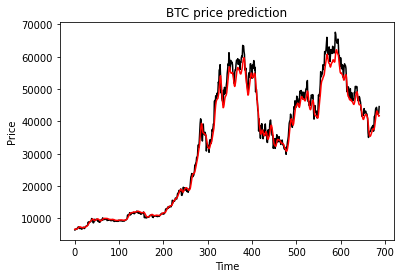

In [13]:
#Test du modèle
testing_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2020,1,1), dt.datetime.now() )
actual_prices = testing_data['Close'].values
actual_prices = actual_prices[89:x]
#actual_prices.shape -> (778,)


#model_inputs = testing_data[len(testing_data) - chunks_size:].values
model_inputs = testing_data['Close'].values

model_inputs = model_inputs.reshape(-1,1)
model_inputs.shape

model_inputs = scaler.fit_transform(model_inputs)
#model_inputs.shape -> (778, 1)

x_test = list()
for x in range( chunks_size, len(model_inputs) ):
    x_test.append( model_inputs[x-chunks_size:x] )
    #print( len(model_inputs[x-chunks_size:x]) )
    
x_test = np.array(x_test)
#print( len(x_test) )
#x_test

#x_test = x_test.reshape( x_test, (x_test.shape[0], x_test.shape[1], 1) )

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='black', label='actual_prices')
plt.plot(prediction_prices, color='red', label='predicted_prices')
plt.title('BTC price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()
